In [4]:
print('The "Liquidity" just started running')

The "Liquidity" just started running


Выбор условий выполнения скрипта:

In [35]:
manual_sending = False # True/False Заполните это поле, если хотите отправить отчет даже после критичных уведомлений

Print_qualuty_check = True # Вынести QC в отдельный excel-файл? True/False
Display_QC_mail = True # Показать письмо QC для отправки? True/False
Send_QC_mail = True # Создать и отправить письмо для QC? True/False

Print_to_excel = True # Создать excel-файл с расчетами? True/False
Display_mail = True # Показать письмо для отправки? True/False
Send_mail = True # Создать и отправить письмо с расчетами и графиком? True/False

mail_to = 'TarakanovMIu@aimmngt.com' # Получатель письма

Необходимые импорты:

In [6]:
import pandas as pd
import numpy as np
from datetime import date, timedelta
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.axes as ax
import openpyxl
from openpyxl.drawing.image import Image
import win32com.client as win32
import os

olApp = win32.Dispatch('Outlook.Application')
olNS = olApp.GetNameSpace('MAPI')

import sys
sys.path.append("C:\\Users\\KlimovaAnnaA\\Documents\\MyFiles\\Projects\\OCP")
from Defs import merge_SalesUnits
from Defs import merge_Mapping
from Defs import Period
from Defs import new_list
from Defs import export_from_RISKCUSTOM
from Defs import add_in_currency_column
from Defs import concat_columns

QC:

In [7]:
query = """
SELECT *
FROM "RISKACCESS"."bankAccountsBalanceDaily"
WHERE "reportDate" >= trunc(sysdate - interval '30' day)
ORDER BY "reportDate"
"""
# check_day = '2024-04-23'
# str_check_day = f"""TO_DATE('{check_day}', 'YYYY-MM-DD')"""
# query = f"""
# SELECT *
# FROM "RISKACCESS"."bankAccountsBalanceDaily"
# WHERE "reportDate" >= trunc(sysdate - interval '30' day) AND "reportDate" < {str_check_day}
# ORDER BY "reportDate"
# """
data_QC_cash = export_from_RISKCUSTOM(query)

# Concat cols and dates
data_QC_cash['missing_record'] = data_QC_cash[['buCode', 'bankId', 'accountCurrency', 'accountNumber']].astype(str).apply(lambda row: '_'.join(row.values.astype(str)), axis=1)
last_date = data_QC_cash.reportDate.unique()[-1]
last_date_str = str(last_date)[:10]
pre_last_date = data_QC_cash.reportDate.unique()[-2]
data_QC_cash_pre_last_date = data_QC_cash.loc[data_QC_cash.reportDate == pre_last_date, 'missing_record'].tolist()
data_QC_cash_last_date = data_QC_cash.loc[data_QC_cash.reportDate == last_date, 'missing_record'].tolist()

# Quality_ckeck.Missing_records
missing_records = [i for i in data_QC_cash_pre_last_date if i not in data_QC_cash_last_date]
data_missing_records = data_QC_cash[(data_QC_cash.missing_record.isin(missing_records)) & (data_QC_cash.reportDate == pre_last_date)]

# Quality_ckeck.New_records
new_records = [i for i in data_QC_cash_last_date if i not in data_QC_cash_pre_last_date]
data_new_records = data_QC_cash[(data_QC_cash.missing_record.isin(new_records)) & (data_QC_cash.reportDate == last_date)]
data_new_records['index_cop'] = data_new_records.index
ind_dict = {}
for ind in data_new_records['index_cop']:
    buCode = data_new_records.loc[ind, 'buCode']
    bankId = data_new_records.loc[ind, 'bankId']
    accountCurrency = data_new_records.loc[ind, 'accountCurrency']
    accountNumber = data_new_records.loc[ind, 'accountNumber']
    
    query = f"""
    SELECT MAX ("reportDate") AS max_value
    FROM "RISKACCESS"."bankAccountsBalanceDaily"
    WHERE "reportDate" >= trunc(sysdate - interval '3' month) and "reportDate" < TO_DATE('{last_date_str}', 'YYYY-MM-DD')
    AND "buCode" = '{buCode}'
    AND "bankId" = '{bankId}'
    AND "accountNumber" = '{accountNumber}'
    AND "accountCurrency" = '{accountCurrency}'
    """
    data_loop_bd = export_from_RISKCUSTOM(query)
    ind_dict[ind] = data_loop_bd.loc[0, 'MAX_VALUE']
data_new_records['index_cop'] = data_new_records['index_cop'].replace(ind_dict).fillna('never')
data_new_records = data_new_records.rename(columns={'index_cop':'Last_seen_at'})

# Quality_ckeck.Mapping
data_QC_cash['Map_holding'] =  merge_SalesUnits(data_QC_cash, col='buCode', merge_col='holding')
data_map_holding = data_QC_cash.loc[(data_QC_cash.Map_holding != data_QC_cash.holding) & (data_QC_cash.reportDate == data_QC_cash.reportDate.max()), ['buCode', 'holding', 'Map_holding']].drop_duplicates()

# Critical alerts
critical_missed_alert = data_missing_records.balanceUsd.sum() >= 5*(10**6)
critical_new_alert = data_new_records.balanceUsd.sum() >= 20*(10**6)
files_list = [x for x in os.listdir() if 'SUEK' in x and '~' not in x]
critical_date_alert = [x for x in files_list if last_date_str in x] != []
# if we have at least one critical alert
missed_alert = 'Alert'
new_alert = 'Alert'
critical_alerts_list = [critical_missed_alert, critical_new_alert, critical_date_alert]
for alert in critical_alerts_list:
    if manual_sending == False:
        if alert == True:
            Print_to_excel = False # Создать excel-файл с расчетами? True/False
            Display_mail =False # Показать письмо для отправки? True/False
            Send_mail = False # Создать и отправить письмо с расчетами и графиком? True/False
        else:
            continue
    elif manual_sending == True:
        Print_qualuty_check = False # Вынести QC в отдельный excel-файл? True/False
        Display_QC_mail = False # Показать письмо QC для отправки? True/False
        Send_QC_mail = False # Создать и отправить письмо для QC? True/False
    if critical_alerts_list.index(alert) == 0:
        missed_alert = 'CRITICAL'
    elif critical_alerts_list.index(alert) == 1:
        new_alert = 'CRITICAL'

# Запись QC в файл:
Output_file = last_date_str + '_Oper_liquidity_QC.xlsx'
if Print_qualuty_check == True : ### PRINT
    data_missing_records.to_excel(Output_file, sheet_name='Пропавшие_счета')
    new_list(data_new_records, Output_file, sheet_name='Новые_счета', index=True)
    new_list(data_map_holding, Output_file, sheet_name='Поиск_в_SalesUnits')

# Отправка письма
mailItem = olApp.CreateItem(0)
mailItem.BodyFormat = 3

mailItem.Subject = f'QC for operational liquidity {last_date_str}' # mail head
# mail body
html_body = f"""<html><body><p>Dear colleagues,<br><br>
Please find attached quality control of daily operational liquidity report as of {last_date_str}:<br><br>
&nbsp;&nbsp; Missed records - {'<span style="color: green;">OK</span>' if data_missing_records.empty else f'<span style="color: red;">{missed_alert}</span>'}<br>
&nbsp;&nbsp; New records - {'<span style="color: green;">OK</span>' if data_new_records.empty else f'<span style="color: red;">{new_alert}</span>'}<br>
&nbsp;&nbsp; Finding in SalesUnits - {'<span style="color: green;">OK</span>' if data_map_holding.empty else '<span style="color: red;">Alert</span>'}<br>
&nbsp;&nbsp; There is already a report for this date - {'<span style="color: green;">No</span>' if critical_date_alert == False else '<span style="color: red;">Yes</span>'}<br><br>
Best regards,<br>
Maksim Tarakanov<br><br>
Whatsapp: +7 915 161 29 12<br>
Financial risk management</p></body></html>"""
mailItem.To = mail_to # mail to
mail_from = 'KlimovaAnnaA@aimmngt.com' # mail from
# mail attachment
mail_attachment = Output_file 


mailItem._oleobj_.Invoke(*(64209, 0, 8, 0, olNS.Accounts.Item(mail_from)))
mailItem.Attachments.Add(os.path.join(os.getcwd(), mail_attachment))
mailItem.HTMLBody = html_body
mailItem.Sensitivity  = 2

# mailItem.Save()
if Display_QC_mail == True: ### DISPLAY
    mailItem.Display()
if Send_QC_mail == True: ### SEND
    mailItem.Send()

C:\Users\KlimovaAnnaA\Documents\MyFiles\Projects\OCP\Defs.py:89: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  data_export = pd.read_sql(query, con=connection)
C:\Users\KlimovaAnnaA\Documents\MyFiles\Projects\OCP\Defs.py:89: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  data_export = pd.read_sql(query, con=connection)
C:\Users\KlimovaAnnaA\Documents\MyFiles\Projects\OCP\Defs.py:34: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '['SUEK' 'SUEK' 'SUEK' ... 'SUEK' 'SUEK' 'SUEK']' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  merge_data.loc[merge_data[f'{id_

Report:

C:\Users\KlimovaAnnaA\Documents\MyFiles\Projects\OCP\Defs.py:89: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  data_export = pd.read_sql(query, con=connection)
C:\Users\KlimovaAnnaA\Documents\MyFiles\Projects\OCP\Defs.py:89: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  data_export = pd.read_sql(query, con=connection)
C:\Users\KlimovaAnnaA\Documents\MyFiles\Projects\OCP\Defs.py:89: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  data_export = pd.read_sql(query, con=connection)
C:\Users\KlimovaAnnaA\Documents\MyFiles\Projects\

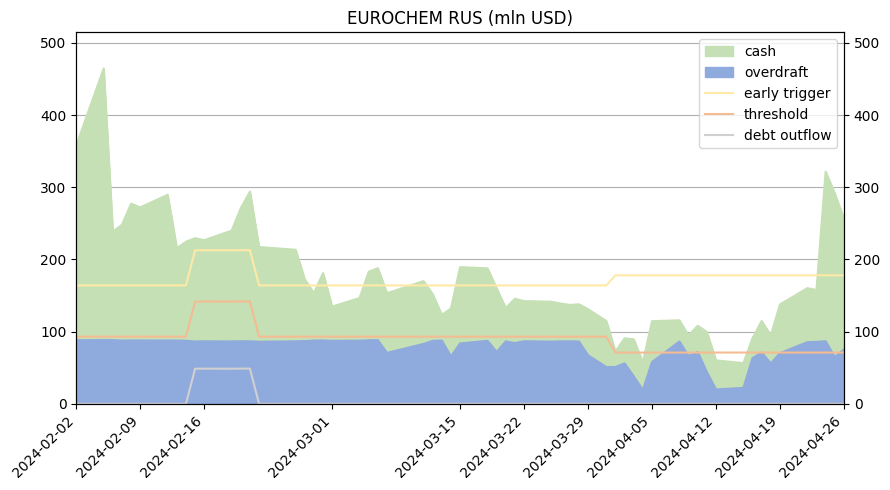

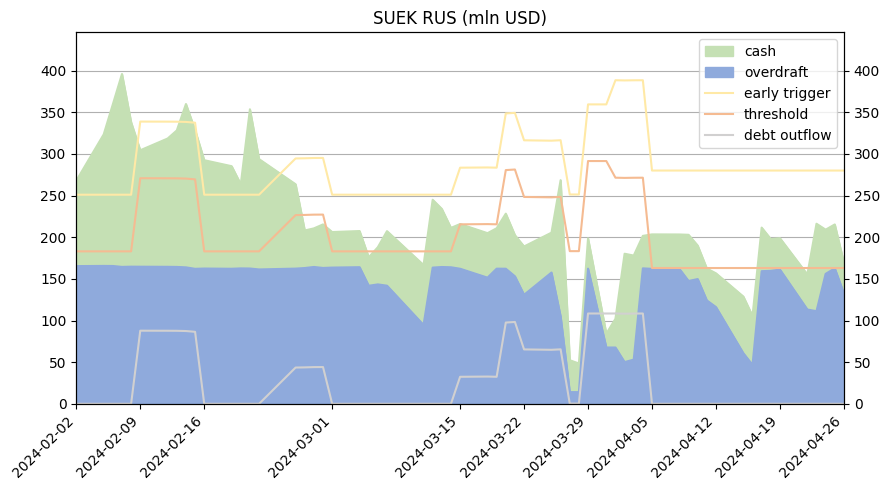

In [36]:
# Cash:
query = """
SELECT "holding", SUM("balanceUsd") AS "cash", "reportDate"
FROM "RISKACCESS"."bankAccountsBalanceDaily"
WHERE "accountStatus" = 'active' AND "bankCountryCode" = 'RU' 
AND "reportDate" >= trunc(sysdate - interval '3' month)
GROUP BY "holding", "reportDate"
ORDER BY "reportDate"
"""
data_cash = export_from_RISKCUSTOM(query)
data_cash['merge_col'] = data_cash[['holding', 'reportDate']].apply(lambda row: '_'.join(row.values.astype(str)), axis=1)
data_cash = data_cash.sort_values(['reportDate', 'holding']).reset_index(drop=True)

# Overdraft:
query = """
SELECT "companyCode" AS "holding", SUM("bookValuePositionCurrency") AS "pre_overdraft", "reportDate"
FROM "RISKACCESS"."sapPositionArrears"
WHERE "productType" = 130 AND "companyCode" IN ('1100', 'E200') 
AND "reportDate" >= trunc(sysdate - interval '3' month) AND "reportDate" <= (SELECT MAX("reportDate") FROM "RISKACCESS"."bankAccountsBalanceDaily")
GROUP BY "companyCode", "reportDate"
ORDER BY "reportDate"
"""
data_overdraft = export_from_RISKCUSTOM(query) # выгрузка запроса
data_overdraft.holding = data_overdraft.holding.replace({'1100': 'SUEK', 'E200':'EUROCHEM'}) # Переименовывание holding
data_overdraft['merge_col'] = data_overdraft[['holding', 'reportDate']].apply(lambda row: '_'.join(row.values.astype(str)), axis=1)
data_overdraft = data_overdraft.sort_values(['reportDate', 'holding']).reset_index(drop=True)

# Финальные подсчеты
data_total = data_cash.merge(data_overdraft, how='outer', left_on='merge_col', right_on='merge_col')
data_total = data_total.loc[~data_total.cash.isna(), ['reportDate_x', 'holding_x', 'cash', 'pre_overdraft']].rename(columns={'reportDate_x':'reportDate', 'holding_x':'holding'}).reset_index(drop=True)
data_total.pre_overdraft = data_total.pre_overdraft.fillna(0) # Заполнение пустых значений pre_overdraft нулями
limit_df = pd.DataFrame({'holding': ['SUEK', 'EUROCHEM'], 'limit': [15000000000, 8000000000]}) # Добавление значения limit для каждого holding
data_total = data_total.merge(limit_df, how='left')
data_total['overdraft'] = data_total.limit - data_total.pre_overdraft # Вычисление overdraft

data_total['CCY'] = 'RUB'
data_total = add_in_currency_column(df=data_total, col_with_CCY='CCY', col_with_VAL='overdraft', CCY_to='USD', date_is_column=True, DATE = 'reportDate')
data_total = data_total.rename(columns={'overdraft_in_USD':'available_ovedraft'})

data_total['total'] = data_total.cash + data_total.available_ovedraft # расчет total
# Триггеры
const_df = pd.DataFrame({'holding':['EUROCHEM', 'SUEK'], 'early_trigger': [164, 251], 'threshold': [93, 183]})
data_total = data_total.merge(const_df, how='left')
data_total.loc[(data_total.reportDate >= '2024-04-01') & (data_total.holding == 'EUROCHEM'), 'threshold'] = 70
data_total.loc[(data_total.reportDate >= '2024-04-01') & (data_total.holding == 'EUROCHEM'), 'early_trigger'] = 159
data_total.loc[(data_total.reportDate >= '2024-04-01') & (data_total.holding == 'SUEK'), 'threshold'] = 159
data_total.loc[(data_total.reportDate >= '2024-04-01') & (data_total.holding == 'SUEK'), 'early_trigger'] = 273

data_total[['cash', 'available_ovedraft', 'total']] = data_total[['cash', 'available_ovedraft', 'total']].astype(int).apply(lambda z: z/10**6)
data_total['day_of_week'] = data_total.reportDate.dt.day_of_week

data_total_dates_sql = [f"TO_DATE('{x}','YYYY-MM-DD')" for x in data_total.reportDate.astype(str).unique().tolist()]
data_total_dates_sql = str(data_total_dates_sql).replace('"','')[1:-1]

query = f"""SELECT * FROM "RISKACCESS"."sapPositionArrears" 
WHERE "reportDate" in ({data_total_dates_sql})
and "remainingTermDays" <= 7
AND "productType" in (130,131,132,133)"""
# "reportDate" >= trunc(sysdate) and "reportDate" <= trunc(sysdate + interval '7' day)
data_Debt = export_from_RISKCUSTOM(query)

data_work_Debt = data_Debt[['reportDate', 'companyName', 'businessPartnerName', 'relationshipPartner', 'productTypeName', 'accountAssignmentLinkName', 'termEnd', 'remainingTermDays','transactionTypeName', 'positionCurrency', 'purchaseValuePositionCurrency', 'purchaseValueDisplayCurrency']]

data_work_Debt['amount'] = data_work_Debt.purchaseValuePositionCurrency * np.sign(data_work_Debt.purchaseValueDisplayCurrency)

data_work_Debt['company_id'] = merge_Mapping(col='companyName', df=data_work_Debt)
data_work_Debt['cty_id'] = merge_Mapping(col='businessPartnerName', df=data_work_Debt)
data_work_Debt['company_holding'] = merge_SalesUnits(col='company_id', df=data_work_Debt, merge_col='holding')
data_work_Debt['cty_holding'] = merge_SalesUnits(col='cty_id', df=data_work_Debt, merge_col='holding')
data_work_Debt['holding_is_equal'] = data_work_Debt['company_holding'] == data_work_Debt['cty_holding']
data_work_Debt.loc[data_work_Debt.company_holding == 'External', 'holding_is_equal'] = False # Если external == External

data_work_Debt = data_work_Debt[(data_work_Debt.relationshipPartner.isin(['Прочие'])) & (data_work_Debt.holding_is_equal == False)] # Фильтр на внешние сделки
data_work_Debt = data_work_Debt[np.sign(data_work_Debt.amount) == -1]
data_work_Debt = add_in_currency_column(data_work_Debt, CCY_to='USD', col_with_CCY= 'positionCurrency', col_with_VAL='amount', DATE='reportDate', date_is_column=True)
data_work_Debt_group = data_work_Debt.groupby(['reportDate', 'company_holding'], as_index=False).agg({'amount_in_USD':'sum'}).rename(columns={'amount_in_USD':'debt'})

data_total = concat_columns(data_total, ['reportDate', 'holding']).reset_index(drop=True)
data_work_Debt_group = concat_columns(data_work_Debt_group, ['reportDate', 'company_holding']).reset_index(drop=True)

data_total['debt_outflow'] = data_total.merge(data_work_Debt_group, right_on='concat_columns', left_on='concat_columns', how='left').iloc[:, -1]
data_total.debt_outflow = data_total.debt_outflow.fillna(0).astype(int).apply(lambda z: z/10**6)
data_total['debt_abs'] = data_total.debt_outflow.abs()
data_total['threshold_debt'] = data_total.threshold + data_total.debt_abs
data_total['early_trigger_debt'] = data_total.early_trigger + data_total.debt_abs

# Графики:
for i in ['EUROCHEM', 'SUEK']:
    data_plot = data_total.query("holding==@i")
    fig, ax = plt.subplots(figsize=(9, 5)) # размер графика
    # Построение фигур и линий
    ax.plot(data_plot.reportDate, data_plot.total, color='#c5e0b4')
    ax.plot(data_plot.reportDate, data_plot.available_ovedraft, color='#8faadc')
    ax.fill_between(data_plot.reportDate, data_plot.total, color='#c5e0b4', label='cash')
    ax.fill_between(data_plot.reportDate, data_plot.available_ovedraft, color='#8faadc', label='overdraft')
    ax.plot(data_plot.reportDate, data_plot.early_trigger_debt, color='#ffe9a6', label='early trigger')
    ax.plot(data_plot.reportDate, data_plot.threshold_debt, color='#f5bb92', label='threshold')
    ax.plot(data_plot.reportDate, data_plot.debt_abs, color='#D1D0D0', label='debt outflow')
    ax.legend(loc='upper right')
    # сетка
    ax.grid(axis='y') 
    ax.set_axisbelow(True)
    # растянуть график по x
    xmin, xmax = data_plot.reportDate.min(), data_plot.reportDate.max() 
    ax.set_xlim([xmin, xmax])
    # растянуть график по y
    ymin, ymax = data_plot.debt_abs.min(), data_plot.total.max() + 50
    ax.set_ylim([ymin, ymax]) 
    ax.twinx().set_ylim(ymin, ymax) # добавить вторую ось y
    # Каждая n-ый день недели в качестве делелния на оси 
    xticks = data_plot.loc[data_plot.day_of_week.isin([4]), 'reportDate'].sort_values().tolist()
    plt.xticks(xticks, rotation=45, ha="right")
    xticks_labels = data_plot.loc[data_plot.day_of_week.isin([4]), 'reportDate'].astype(str).sort_values().tolist()
    ax.set_xticklabels(xticks_labels, rotation=45, ha="right" )
    plt.title(f'{i} RUS (mln USD)') # название графика

    plt.tight_layout()
    plt.savefig(f'{i}.png')

# Запись в файл:
TD = data_total.reportDate.max()
TD_str = str(TD)[:10]
Output_file_SUEK = TD_str + '_Oper_liquidity_SUEK.xlsx'
Output_file_ECH = TD_str + '_Oper_liquidity_EUROCHEM.xlsx'
if Print_to_excel == True:
    for i in ['EUROCHEM', 'SUEK']:
        data_print = data_total.query("holding==@i")[['reportDate', 'cash', 'available_ovedraft', 'total', 'debt_outflow','early_trigger', 'threshold']]
        Output_file = TD_str + '_Oper_liquidity_' + i + '.xlsx'
        data_print.to_excel(Output_file, index=False)
        # Create a new or open existing Excel file with openpyxl
        wb = openpyxl.load_workbook(Output_file)  # Open existing or create new
        ws = wb.active
        # Error handling: Check if image file exists
        try:
            img = Image(f'{i}.png')
        except FileNotFoundError:
            print("Error: Image file 'EUROCHEM.png' not found. Skipping image insertion.")
            img = None  # Set img to None to avoid potential errors
        # Insert image if it exists
        if img:
            img.anchor = 'H37'  # Adjust cell reference as needed
            ws.add_image(img)
        # Save the Excel file (overwrite if existing)
        wb.save(Output_file)

# Создание писем:
for i in ['EUROCHEM', 'SUEK']:
    mailItem = olApp.CreateItem(0)
    mailItem.BodyFormat = 3

    mailItem.Subject = f'Operational liquidity {i} RUS {TD_str}' # mail head
    # mail body
    html_body = f"""<html><body><p>Dear colleagues,<br><br>
    Please find attached daily operational liquidity report as of {TD_str}<br>
    <img src="{(os.path.join(os.getcwd(), i))}.png"><br>
    Below early trigger – to analyze if there is an issue with revenue collection and if there is a risk of threshold violation<br>
    Below threshold – an action plan to return above the threshold<br><br>
    Best regards,<br>
    Maksim Tarakanov<br><br>
    Whatsapp: +7 915 161 29 12<br>
    Financial risk management</p></body></html>"""
    mailItem.To = mail_to # mail to
    mail_from = 'KlimovaAnnaA@aimmngt.com' # mail from
        # mail attachment
    if i == 'SUEK':
        mail_attachment = Output_file_SUEK 
    if i == 'EUROCHEM':
        mail_attachment = Output_file_ECH 

    mailItem._oleobj_.Invoke(*(64209, 0, 8, 0, olNS.Accounts.Item(mail_from)))
    mailItem.Attachments.Add(os.path.join(os.getcwd(), mail_attachment))
    mailItem.HTMLBody = html_body
    mailItem.Sensitivity  = 2

    # mailItem.Save()
    if Display_mail == True:
        mailItem.Display()
    if Send_mail == True:
        mailItem.Send()

In [9]:
data_cash.shape, data_overdraft.shape, data_total.shape

((120, 4), (68, 4), (120, 18))

In [10]:
print('The "Liquidity" was finished')

The "Liquidity" was finished


In [18]:
data_missing_records.columns
# data_missing_records.accountStatus
data_missing_records

,##batch_id,##deleted,##inserted,##origin_name,reportDate,holding,buCode,buCountryGroup,buCountryCode,buName,...,bankId,bankCountryCode,bankCountryGroup,accountCurrency,accountNumber,accountStatus,balance,balanceUsd,statementDate,missing_record
65119,35949607@WHPROD,N,2024-04-27 12:55:13,WHFLEX,2024-04-25,EUROCHEM,BRCPQ,(6) BR,BR,BRCPQ EC Com Prod Quim,...,EVERCN,CN,(5) CN,BRL,FTN36937626000016,active,20508.71,3923.685167,2024-04-19,BRCPQ_EVERCN_BRL_FTN36937626000016
65120,35949607@WHPROD,N,2024-04-27 12:55:13,WHFLEX,2024-04-25,EUROCHEM,BRCPQ,(6) BR,BR,BRCPQ EC Com Prod Quim,...,EVERCN,CN,(5) CN,BRL,FTN36937626000016,active,20508.71,3940.724017,2024-04-22,BRCPQ_EVERCN_BRL_FTN36937626000016
65121,35949607@WHPROD,N,2024-04-27 12:55:13,WHFLEX,2024-04-25,EUROCHEM,BRCPQ,(6) BR,BR,BRCPQ EC Com Prod Quim,...,EVERCN,CN,(5) CN,BRL,FTN36937626000016,active,20508.71,3972.554527,2024-04-23,BRCPQ_EVERCN_BRL_FTN36937626000016
65300,35949607@WHPROD,N,2024-04-27 12:55:13,WHFLEX,2024-04-25,EUROCHEM,BRFTO,(6) BR,BR,Fertilizantes Tocantins S.A.,...,EVERCN,CN,(5) CN,BRL,FTN36937626000015,active,250479.51,48129.337279,2024-04-22,BRFTO_EVERCN_BRL_FTN36937626000015
65301,35949607@WHPROD,N,2024-04-27 12:55:13,WHFLEX,2024-04-25,EUROCHEM,BRFTO,(6) BR,BR,Fertilizantes Tocantins S.A.,...,EVERCN,CN,(5) CN,BRL,FTN36937626000015,active,250479.51,48518.093596,2024-04-23,BRFTO_EVERCN_BRL_FTN36937626000015


Проверки выполнения кода:

In [11]:
# AECOR NRAKAE USD 0183052684002
# AETRD ZANDAE USD 0311000000019901
date_1 = '2024-04-18'
date_2 = '2024-04-23'
buCode_list = ['AECOR', 'AETRD']
bankId_list = ['NRAKAE', 'ZANDAE']
accountNumber_list = ['USD']
accountCurrency_list = ['0183052684002', '0311000000019901']

query = f"""
SELECT "reportDate", "buCode", "bankId", "accountNumber", "accountCurrency"
FROM "RISKACCESS"."bankAccountsBalanceDaily"
WHERE "reportDate" >= TO_DATE('{date_1}', 'YYYY-MM-DD') 
AND "reportDate" <= TO_DATE('{date_2}', 'YYYY-MM-DD')
AND "buCode" in ({str(buCode_list)[1:-1]})
AND "bankId" in ({str(bankId_list)[1:-1]})
"""
# AND "accountNumber" in ({str(accountNumber_list)[1:-1]})
# AND "accountCurrency" in ({str(accountCurrency_list)[1:-1]})
data_check = export_from_RISKCUSTOM(query)
data_check = data_check[(data_check.accountNumber.isin(accountCurrency_list)) & (data_check.accountCurrency.isin(accountNumber_list))]
data_check

C:\Users\KlimovaAnnaA\Documents\MyFiles\Projects\OCP\Defs.py:89: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  data_export = pd.read_sql(query, con=connection)


,reportDate,buCode,bankId,accountNumber,accountCurrency
1,2024-04-18,AECOR,NRAKAE,0183052684002,USD
5,2024-04-18,AETRD,ZANDAE,0311000000019901,USD
12,2024-04-19,AECOR,NRAKAE,0183052684002,USD
15,2024-04-19,AETRD,ZANDAE,0311000000019901,USD
21,2024-04-23,AECOR,NRAKAE,0183052684002,USD
26,2024-04-23,AETRD,ZANDAE,0311000000019901,USD


In [12]:
data_QC_cash.reportDate.drop_duplicates()

0       2024-04-02
3619    2024-04-03
7233    2024-04-04
10847   2024-04-05
14458   2024-04-08
18068   2024-04-09
21663   2024-04-10
25258   2024-04-11
28853   2024-04-12
32449   2024-04-15
36088   2024-04-16
39729   2024-04-17
43370   2024-04-18
47010   2024-04-19
50647   2024-04-22
54307   2024-04-23
57979   2024-04-24
61734   2024-04-25
65491   2024-04-26
Name: reportDate, dtype: datetime64[ns]